In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### data creation

In [2]:
x = np.arange(0, 10, 0.5)
y = np.sin(x)
z = np.random.normal(0, 0.1, 20)
x.shape, y.shape, z.shape

((20,), (20,), (20,))

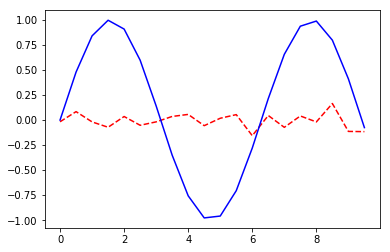

In [3]:
plt.plot(x, z, '--r')
plt.plot(x, y, 'b')
plt.show()

In [4]:
x = x.reshape([-1, 1])
y = y.reshape([-1, 1])
z = z.reshape([-1, 1])
x.shape, y.shape, z.shape

((20, 1), (20, 1), (20, 1))

In [5]:
x_inp = np.hstack([y, z])
x_inp.shape

(20, 2)

In [6]:
inds = np.arange(20)
x_inds = np.array([inds[i:i+5] for i in range(10)])
y_inds = np.array([inds[i+5:i+10] for i in range(10)])

In [7]:
y_inds

array([[ 5,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11, 12],
       [ 9, 10, 11, 12, 13],
       [10, 11, 12, 13, 14],
       [11, 12, 13, 14, 15],
       [12, 13, 14, 15, 16],
       [13, 14, 15, 16, 17],
       [14, 15, 16, 17, 18]])

In [8]:
k = 0
def next_batch(batch_size, k):
    if k >= 10:
        k = 0
    x_batch = x_inp[x_inds[k:k+batch_size]]
    y_batch = y[y_inds[k:k+batch_size]]
    k += batch_size
    
    return x_batch, y_batch, k

In [9]:
x_batch, y_batch, k = next_batch(5, k)
x_batch, y_batch, k

(array([[[ 0.        , -0.01687228],
         [ 0.47942554,  0.08439883],
         [ 0.84147098, -0.01826474],
         [ 0.99749499, -0.07171815],
         [ 0.90929743,  0.03560053]],
 
        [[ 0.47942554,  0.08439883],
         [ 0.84147098, -0.01826474],
         [ 0.99749499, -0.07171815],
         [ 0.90929743,  0.03560053],
         [ 0.59847214, -0.05187375]],
 
        [[ 0.84147098, -0.01826474],
         [ 0.99749499, -0.07171815],
         [ 0.90929743,  0.03560053],
         [ 0.59847214, -0.05187375],
         [ 0.14112001, -0.01782329]],
 
        [[ 0.99749499, -0.07171815],
         [ 0.90929743,  0.03560053],
         [ 0.59847214, -0.05187375],
         [ 0.14112001, -0.01782329],
         [-0.35078323,  0.03623696]],
 
        [[ 0.90929743,  0.03560053],
         [ 0.59847214, -0.05187375],
         [ 0.14112001, -0.01782329],
         [-0.35078323,  0.03623696],
         [-0.7568025 ,  0.05663116]]]), array([[[ 0.59847214],
         [ 0.14112001],
         [-0.

### The LSTM

In [10]:
enc_inp = [tf.placeholder(tf.float32, shape=[None, 2], name='enc_inp') for i in range(5)]
target = [tf.placeholder(tf.float32, shape=[None, 1], name='dec_out') for i in range(5)]
dec_inp = [tf.zeros_like(target[0], dtype=np.float32, name="GO")]+\
          target[0:-1]

In [11]:
enc_inp

[<tf.Tensor 'enc_inp:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'enc_inp_1:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'enc_inp_2:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'enc_inp_3:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'enc_inp_4:0' shape=(?, 2) dtype=float32>]

In [12]:
dec_inp

[<tf.Tensor 'GO:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out_1:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out_2:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out_3:0' shape=(?, 1) dtype=float32>]

In [13]:
target

[<tf.Tensor 'dec_out:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out_1:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out_2:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out_3:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dec_out_4:0' shape=(?, 1) dtype=float32>]

In [14]:
n_hiddens = 2
cells = [tf.contrib.rnn.BasicLSTMCell(n_hiddens, forget_bias=1.0) for i in range(2)]
cell = tf.contrib.rnn.MultiRNNCell(cells)

In [16]:
dec_outputs, dec_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )

In [17]:
def _weight(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def _bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

w_out = _weight([2, 1])
b_out = _bias([1])
output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    
results = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

# reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [18]:
# Optmizer: 
l_r = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 150  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update

output_loss = 0
for _y, _Y in zip(results, target):
    output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
# L2 regularization (to avoid overfitting and to have a  better generalization capacity)
# reg_loss = 0
# for tf_var in tf.trainable_variables():
#     if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
#         reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

op = tf.train.RMSPropOptimizer(l_r, decay=lr_decay, momentum=momentum).minimize(output_loss)

In [68]:
epoch = 500
batch_size = 5
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epo in range(epoch):
        for i in range(2):
            x_batch, y_batch, k = next_batch(batch_size, k)
            feed_dict = {enc_inp[t]: x_batch[t] for t in range(len(enc_inp))}
            feed_dict.update({target[t]: y_batch[t] for t in range(len(target))})
            _ = sess.run([op], feed_dict=feed_dict)
            loss = sess.run([output_loss], feed_dict=feed_dict)
        if (epo+1)%10 == 0:
            print('Epoch:', epo+1, 
                  'Loss:', loss)
    feed_dict = {enc_inp[t]: x_inp[x_inds[0]][t].reshape([-1, 2]) for t in range(len(enc_inp))}
    feed_dict.update({target[t]: y[y_inds[0]][t].reshape([-1, 1]) for t in range(len(target))})
    y_pred1 = sess.run(results, feed_dict=feed_dict)
    y_pred1 = np.array(y_pred1).reshape([-1, 1])
    
    inp = np.hstack([y_pred1, z[y_inds[5]]])
    feed_dict = {enc_inp[t]: inp[t].reshape([-1, 2]) for t in range(len(enc_inp))}
    feed_dict.update({target[t]: y[y_inds[5]][t].reshape([-1, 1]) for t in range(len(target))})
    y_pred2 = sess.run(results, feed_dict=feed_dict)
    y_pred2 = np.array(y_pred2).reshape([-1, 1])
    
    print('Done.')

Epoch: 10 Loss: [6.6787739]
Epoch: 20 Loss: [5.8191824]
Epoch: 30 Loss: [2.3903489]
Epoch: 40 Loss: [2.1866724]
Epoch: 50 Loss: [1.638483]
Epoch: 60 Loss: [1.1801045]
Epoch: 70 Loss: [0.79048061]
Epoch: 80 Loss: [0.5168702]
Epoch: 90 Loss: [0.35563529]
Epoch: 100 Loss: [0.24680404]
Epoch: 110 Loss: [0.16980876]
Epoch: 120 Loss: [0.12039174]
Epoch: 130 Loss: [0.084257081]
Epoch: 140 Loss: [0.069069177]
Epoch: 150 Loss: [0.044432793]
Epoch: 160 Loss: [0.037419766]
Epoch: 170 Loss: [0.026373051]
Epoch: 180 Loss: [0.022690222]
Epoch: 190 Loss: [0.017315939]
Epoch: 200 Loss: [0.013590805]
Epoch: 210 Loss: [0.010599094]
Epoch: 220 Loss: [0.0082614031]
Epoch: 230 Loss: [0.025320031]
Epoch: 240 Loss: [0.011863071]
Epoch: 250 Loss: [0.0055392953]
Epoch: 260 Loss: [0.0055746175]
Epoch: 270 Loss: [0.0067847068]
Epoch: 280 Loss: [0.0043501044]
Epoch: 290 Loss: [0.0036425616]
Epoch: 300 Loss: [0.0041910424]
Epoch: 310 Loss: [0.0043434268]
Epoch: 320 Loss: [0.0051118457]
Epoch: 330 Loss: [0.00297536

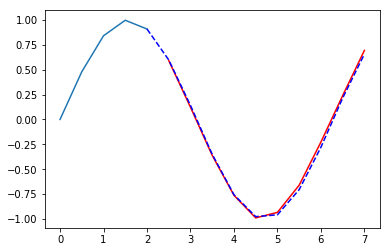

In [69]:
y_pred = np.vstack([y_pred1, y_pred2])

plt.plot(x[x_inds[0]], x_inp[x_inds[0], 0])
plt.plot(x[5:15], y_pred, 'r') # pred 
plt.plot(x[4:15], y[4:15], '--b') # real 
plt.show()

In [58]:
y_pred1

array([[ 0.29015023],
       [ 0.18072164],
       [-0.33479571],
       [-0.77907753],
       [-0.91983753]], dtype=float32)

In [22]:
y[y_inds[0]]

array([[ 0.59847214],
       [ 0.14112001],
       [-0.35078323],
       [-0.7568025 ],
       [-0.97753012]])

In [32]:
x_inp[x_inds[0], 0]

array([ 0.        ,  0.47942554,  0.84147098,  0.99749499,  0.90929743])

In [37]:
y

array([[ 0.        ],
       [ 0.47942554],
       [ 0.84147098],
       [ 0.99749499],
       [ 0.90929743],
       [ 0.59847214],
       [ 0.14112001],
       [-0.35078323],
       [-0.7568025 ],
       [-0.97753012],
       [-0.95892427],
       [-0.70554033],
       [-0.2794155 ],
       [ 0.21511999],
       [ 0.6569866 ],
       [ 0.93799998],
       [ 0.98935825],
       [ 0.79848711],
       [ 0.41211849],
       [-0.07515112]])